# <div style="text-align:center;">CSCN8030 - Artificial Intelligence for Business Transformation</div>
# <div style="text-align:center;">Project 5 - TikTok</div>
### <div style="text-align:center;">Troy Mazerolle, Samiksha Rajpal, Aerish Gaba</div>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
from wordcloud import WordCloud
# from transformers import TFBartForConditionalGeneration, BartTokenizer

In [47]:
# Helper Functions

def remove_past_first_decimal(version_number):
    parts = version_number.split('.')
    truncated_version = '.'.join(parts[:1])
    return int(truncated_version)

def weighted_average_and_count(x):
    weighted_mean = (x['Sentiment'] * x['upvotes']).sum() / x['upvotes'].sum()
    count = x['Sentiment'].count().astype(int)
    merged_comments = " ".join(x['review_text'])
    return pd.Series({'weighted_mean': weighted_mean, 'count': count, "merged_comments": merged_comments})

# def split_decimal_strings_to_dataframe(decimal_strings):
#     before_decimal = [int(decimal_string.split('.')[0]) for decimal_string in decimal_strings]
#     after_decimal = [int(decimal_string.split('.')[1]) for decimal_string in decimal_strings]
#     result_df = pd.DataFrame({'major_version_number': before_decimal, 'minor_version_number': after_decimal})
#     return result_df

# def comment_summarizer(very_long_text):
#     model = TFBartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
#     tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
#     max_chunk_length = 1024
#     chunks = [very_long_text[i:i+max_chunk_length] for i in range(0, len(very_long_text), max_chunk_length)]
#     summaries = []
#     for chunk in chunks:
#         input_ids = tokenizer.encode(chunk, return_tensors="pt", max_length=max_chunk_length, truncation=True)
#         summary_ids = model.generate(input_ids, max_length=56, num_beams=4, early_stopping=True)
#         summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#         summaries.append(summary)
#     overall_summary = " ".join(summaries)
#     return overall_summary

## Feature Engineering

Before beginning, we do the following manipulations to the data:
* Drop all NA values in the `review_text` and `app_version` columns
* Clean `app_version` to only have numbers and no letters
* Take only the major versions of `app_version` and ignore minor versions
  * For example, version 21.4.3 and version 21.2.4 will be grouped under version 21
* Simplify `posted_date` to only be month and year
* Add 1 to every amount of upvotes
  * This is only so that there is at least 1 upvote for when upvotes are used as weights

In [48]:
tiktok = pd.read_csv("G:/My Drive/University of Waterloo Files/Applied Machine Learning and Artificial Intelligence/Term 2/CSCN 8030 - Artificial Intelligence for Business Transformation/Projects (LINK SHARING ON)/Project 5/tiktok_app_reviews.csv")
tiktok = tiktok[~tiktok['review_text'].isna()].reset_index(drop=True)
tiktok = tiktok[~tiktok['app_version'].isna()].reset_index(drop=True)
tiktok["app_version"] = [string.replace('v', '') for string in tiktok["app_version"]]
tiktok["app_version"] = [remove_past_first_decimal(string) for string in tiktok["app_version"]]
tiktok["posted_date"] = [datetime.strptime(date_time_string.split(' ')[0], '%Y-%m-%d').strftime('%Y-%m') for date_time_string in tiktok["posted_date"]]
tiktok["upvotes"] += 1
tiktok.head()

C:\Users\tjmaz\AppData\Local\Temp\ipykernel_44036\328954195.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tiktok = pd.read_csv("G:/My Drive/University of Waterloo Files/Applied Machine Learning and Artificial Intelligence/Term 2/CSCN 8030 - Artificial Intelligence for Business Transformation/Projects (LINK SHARING ON)/Project 5/tiktok_app_reviews.csv")


,review_id,review_text,upvotes,app_version,posted_date
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,It is an excellent solution to finding videos ...,403,21,2021-09
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,Great app works really well so many features s...,68,21,2021-09
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,I down loaded app but didnt work . i love this...,25,21,2021-09
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,19,21,2021-09
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,Currently it's working good for me except a fe...,233,21,2021-09


## Sentiment Analysis

Using SentimentIntensityAnalyzer from nltk, we can get the sentiment of each comment.  We do so and add it to the data.  Note that the sentiments range from -1 to 1 where negative sentiments correspond to a negative number and positive sentiments correspond to a positive number.

In [49]:
sentiments = []
sia = SentimentIntensityAnalyzer()
texts = tiktok["review_text"]
for i, text in enumerate(texts):
    sentiments.append(sia.polarity_scores(str(text))["compound"])
    # if i % 100000 == 0:
    #     print(f'{i}/{len(texts)}')
tiktok["Sentiment"] = sentiments
tiktok.head(10)

,review_id,review_text,upvotes,app_version,posted_date,Sentiment
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,It is an excellent solution to finding videos ...,403,21,2021-09,0.9442
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,Great app works really well so many features s...,68,21,2021-09,0.9805
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,I down loaded app but didnt work . i love this...,25,21,2021-09,0.9237
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,19,21,2021-09,0.8101
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,Currently it's working good for me except a fe...,233,21,2021-09,-0.1708
5,gp:AOqpTOEx7_3L-70CUZHq9z_GZPidQ89dzjsV6HUTAeg...,"I love everything about the app, but when tryi...",56,21,2021-09,0.8793
6,gp:AOqpTOEbWy_Nja8_fufeCvWqui1ziaMGOHom3gnVdjc...,"Love the app, the downside is the promotion fi...",81,21,2021-09,0.4019
7,gp:AOqpTOH9T_OygNepOd_HoGaL3tr5a5YPmJuIV73lemg...,A very educational and fun app. I've met alot ...,18,21,2021-09,0.8707
8,gp:AOqpTOGAvlJNI6g1IV0BGnCdh-Lutd9wNECKaz6vGXe...,"Love, love, love this app!!! Cannot wait to ma...",13,21,2021-09,0.9768
9,gp:AOqpTOHP98t8WpywjlLr6hzCLrnM5Hw5EJLYv_NSwE9...,My wifi is great and all my other apps work gr...,10,21,2021-09,0.2441


## Weighted Average by Version

Now that we have the sentiments of each comment, we can group the data by `app_version` and take the average of sentiments per version weighted by the amount of upvotes each comment has.

,app_version,weighted_mean,count,merged_comments
0,0,0.463510,877,I love Tiktok because its so fun not only to w...
1,1,0.492147,1783,I love this app!! Its amazing to see so many p...
2,4,0.645935,112341,"This app is so awesome! However, I think it wo..."
3,5,0.594746,81917,This app is amazing I've made some close frien...
4,6,0.560136,59184,It's fun you get your heart pumping and you ca...
5,7,0.486178,64583,i freaking loveeee this app! ive used it since...
6,8,0.462029,99214,Actually it's a ready good apse But for a week...
7,9,0.460922,145298,Hi i am very happy to see te all new features ...
8,10,0.580185,94425,Tik Tok is a very fun way to express who you a...
9,11,0.406796,124377,Tiktok is very fun with a lot of good content....


Text(0.5, 1.0, 'Sentiments of TikTok across Versions')

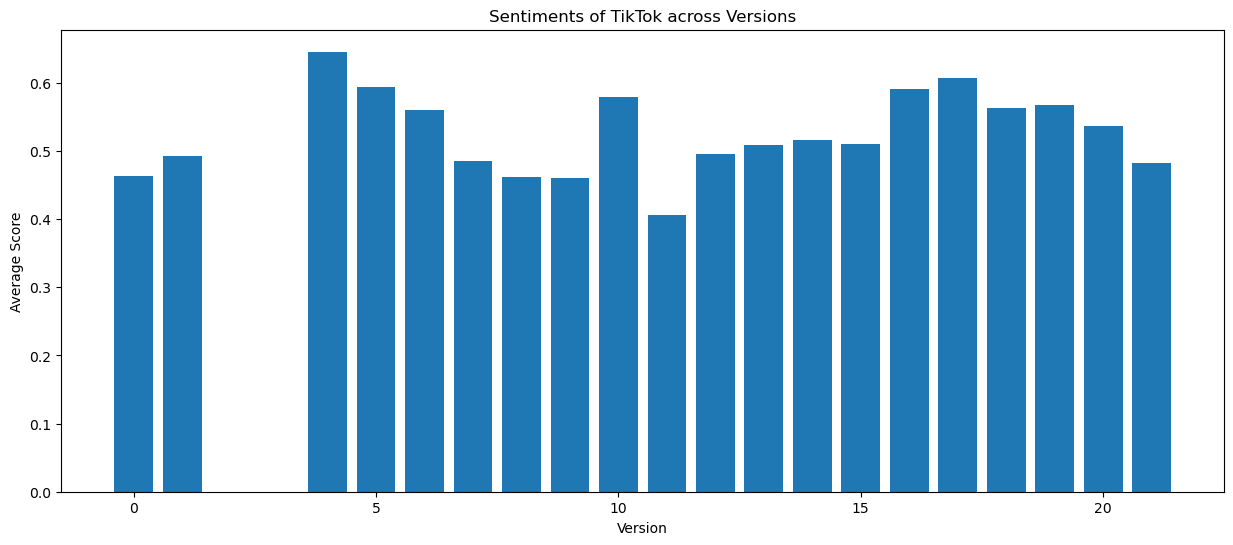

In [50]:
weighted_average_by_category = tiktok.groupby('app_version').apply(weighted_average_and_count)
weighted_average_by_category = weighted_average_by_category.sort_values(by="app_version")
weighted_average_by_category.reset_index(drop=False, inplace=True)

display(weighted_average_by_category)

plt.figure(figsize=(15, 6))
plt.bar(weighted_average_by_category["app_version"], weighted_average_by_category["weighted_mean"])
plt.xlabel('Version')
plt.ylabel('Average Score')
plt.title('Sentiments of TikTok across Versions')


Below we show a word cloud of the comments of the best version of TikTok.

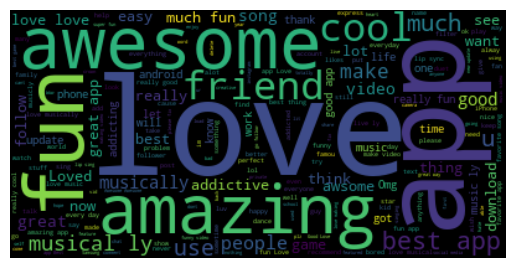

In [51]:
best_version_comments = weighted_average_by_category["merged_comments"][np.argmax(weighted_average_by_category["weighted_mean"])]

wordcloud = WordCloud().generate(best_version_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Below we show a word cloud of the comments of the worst version of TikTok.

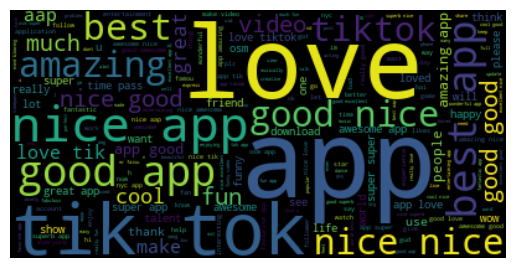

In [52]:
worst_version_comments = weighted_average_by_category["merged_comments"][np.argmin(weighted_average_by_category["weighted_mean"])]

wordcloud = WordCloud().generate(worst_version_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Weighted Average by Date

Now that we have the sentiments of each comment, we can group the data by `posted_date` and take the average of sentiments per month weighted by the amount of upvotes each comment has.

,posted_date,weighted_mean,count,merged_comments
0,2015-07,0.460091,151,I've been waiting for this day omg thank you ❤...
1,2015-08,0.478907,425,But the update for my Samsung Galaxy s6 now ma...
2,2015-09,0.537824,424,"Only thing is, I wish it had all the features ..."
3,2015-10,0.456494,655,I rate 5 stars because of the way that communi...
4,2015-11,0.499582,1098,Hate would work or doesn't download It is the ...
...,...,...,...,...
70,2021-05,0.547266,62531,"I love using this app, it's content wheel seem..."
71,2021-06,0.579206,65041,Realy good app! Definently recommend! But stuf...
72,2021-07,0.583122,67702,Great creative outlet and way to find and conn...
73,2021-08,0.444623,69144,"I can't clear Downloads in catch and Data, But..."


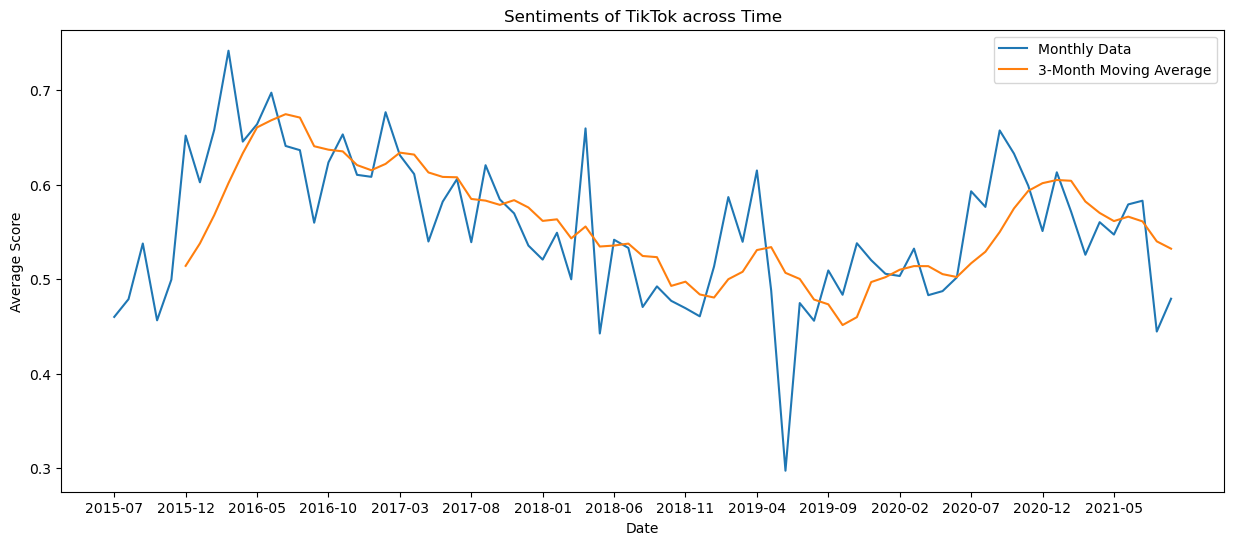

In [53]:
weighted_average_by_date = tiktok.groupby('posted_date').apply(weighted_average_and_count)
weighted_average_by_date = weighted_average_by_date.sort_values(by="posted_date")
weighted_average_by_date.reset_index(drop=False, inplace=True)

# versions = split_decimal_strings_to_dataframe(weighted_average_by_category["app_version"])
# weighted_average_by_category = pd.concat([weighted_average_by_category, versions], axis = 1)
# weighted_average_by_category = weighted_average_by_category.sort_values(by = "minor_version_number", ascending=True)
# weighted_average_by_category = weighted_average_by_category.sort_values(by = "major_version_number")

display(weighted_average_by_date)

plt.figure(figsize=(15, 6))
plt.plot(weighted_average_by_date["posted_date"], weighted_average_by_date["weighted_mean"], label = "Monthly Data")
plt.xticks(range(0, len(weighted_average_by_date["posted_date"]), 5))
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.title('Sentiments of TikTok across Time')

rolling_avg = weighted_average_by_date['weighted_mean'].rolling(window=6).mean()
plt.plot(weighted_average_by_date["posted_date"], rolling_avg, label = "3-Month Moving Average")

plt.legend()

Below we show a word cloud of the comments of the best month of TikTok.

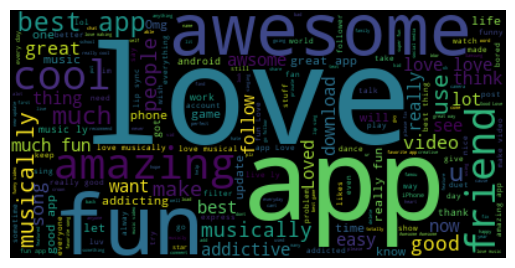

In [54]:
best_date_comments = weighted_average_by_date["merged_comments"][np.argmax(weighted_average_by_date["weighted_mean"])]

wordcloud = WordCloud().generate(best_version_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Below we show a word cloud of the comments of the worst month of TikTok.

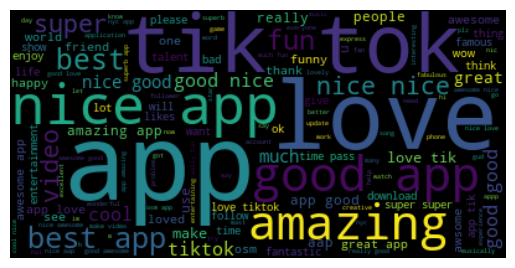

In [55]:
worst_date_comments = weighted_average_by_date["merged_comments"][np.argmin(weighted_average_by_date["weighted_mean"])]

wordcloud = WordCloud().generate(worst_date_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## What are the Best and Worst Comments Saying?

To better understand what the bpositive and negative comments are saying, we will look at some examples.  To do this, we will filter out the negative and positive sentiments respectively, and output the top few comments that have the most amount of upvotes.

We get the following negative comments:

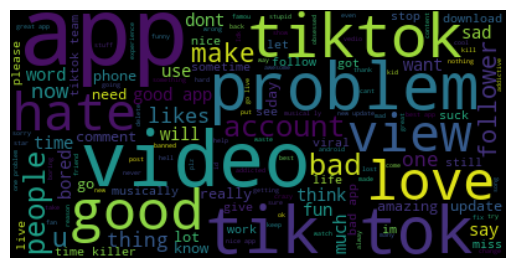

this app is good but it dosent give me the new stickers and new effects even after reporting and after updating i have no idea whats happening .
Something for Everyone in this app! Always find something to smile about. Ads are unobtrusive and do not force you to sit and watch for even 1 second. All it takes is a swipe, and ads are gone. Ads are not pervasive, and do not keep repeating and coming back. There are still a couple of bugs and glitches, but they are minor and not problematic. I Love the people here! All types of subjects and topics are in the videos, tailored to the user's preferences and there is something for everyone.
Horrible . Horrilby good
This app is amazing!! This is very interesting and you can spend hours on it without getting bored, but there are many problems, minor problems and big problems. For example there will be a big problem that tiktok is deleting random videos that really bothers me, some of my favorite videos have been deleted for no reason, and another

In [56]:
negative_comments = tiktok[tiktok["Sentiment"] < 0]
negative_comments = negative_comments.sort_values(by="upvotes", ascending=False)
wordcloud = WordCloud().generate(" ".join(negative_comments["review_text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

for comment in negative_comments["review_text"][:4]:
    print(comment)

and we get the following positive comments:

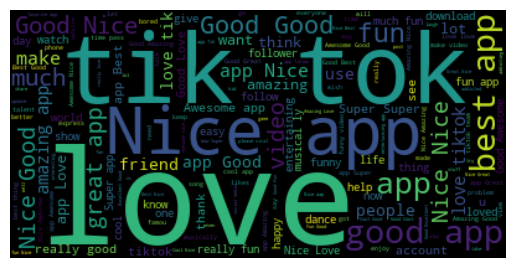

This app is good. We can connect to the world by this app. We can also spend our time if we are bored. But we should not be addict to it. I have seen people wasting their money for clothes and make-up for making videos. I have also seen people making videos of others in public places and cars. That must be avoided. This app increases our skill of acting too. I love this app. I want to just suggest that if tje touch magic will be there, it will be more interesting. THANK YOU !!!! ❤❤❤
I love this Application but please add different methods to withdrawal money please like jazzcash easypaisa please thankyou
This app is perfect for people. I'm 13 and my mom won't even let me have Snapchat, Instagram, Twitter or nothing. I asked my mom about this app and she did research. She said this app is perfect and I can have it. My mom is very protective of me and she makes sure my account is private. My mom loves this app and so do I. Thank you Tik Tok!!❤❤❤
I really enjoy the app, very much, but the

In [57]:
positive_comments = tiktok[tiktok["Sentiment"] > 0]
positive_comments = positive_comments.sort_values(by="upvotes", ascending=False)
wordcloud = WordCloud().generate(" ".join(positive_comments["review_text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

for comment in positive_comments["review_text"][:4]:
    print(comment)

Lastly, to hone in on the problems that TikTok may be facing, we look at the top comments of the negative comments that contain the word "problem".  We get the following:

In [58]:
contains_problem = [True if "problem" in s else False for s in negative_comments["review_text"]]
negative_comments_contains_problem = negative_comments[contains_problem]
negative_comments_contains_problem = negative_comments_contains_problem.sort_values(by="upvotes", ascending=False)
for comment in negative_comments_contains_problem["review_text"][:4]:
    print(comment)

Something for Everyone in this app! Always find something to smile about. Ads are unobtrusive and do not force you to sit and watch for even 1 second. All it takes is a swipe, and ads are gone. Ads are not pervasive, and do not keep repeating and coming back. There are still a couple of bugs and glitches, but they are minor and not problematic. I Love the people here! All types of subjects and topics are in the videos, tailored to the user's preferences and there is something for everyone.
This app is amazing!! This is very interesting and you can spend hours on it without getting bored, but there are many problems, minor problems and big problems. For example there will be a big problem that tiktok is deleting random videos that really bothers me, some of my favorite videos have been deleted for no reason, and another big problem is community, people in the comments always say mean things to the creators of this video and it really bugs me because I feel so bad for them.
This is a gre